In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.linalg import qr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from qmlbo import spectrum, bitops, models


### Plot Figure 6 (Appendix C)

In [4]:
def qr_haar(N):
    """Generate a Haar-random matrix using the QR decomposition.
    
    See: https://pennylane.ai/qml/demos/tutorial_haar_measure.html
    """
    # Step 1
    A, B = np.random.normal(size=(N, N)), np.random.normal(size=(N, N))
    Z = A + 1j * B

    # Step 2
    Q, R = qr(Z)

    # Step 3
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])

    # Step 4
    return np.dot(Q, Lambda)


def nu_opt_haar_avg(R, k, d):

    if k == 0:
        return (R(k) + d) / (d * (d + 1))
        
    return R(k) / (d * (d + 1))
    
    
def nu_opt_haar_var_golomb(k, d):
    if k == 0:
        return 0 # not implemented
    D = (d+3) * (d+2) * (d+1) * d
    return (3 * d**2 - d) / (D * d * (d+1))


def nu_opt_haar_var_binary(k, d):
    D = (d+3) * (d+2) * (d+1) * d
    k = abs(k)
    if 2*k > d:
        out =  (3*(d-k)*d*(d+1) - (d-k)**2 * (4*d + 6)) / (D * d * (d+1))
    else:
        out = ((5*d-7*k)*d*(d+1) - (d-k)**2 * (4*d + 6)) / (D * d * (d+1))
    if k == 0:
        return 0 # not implemented
    return out


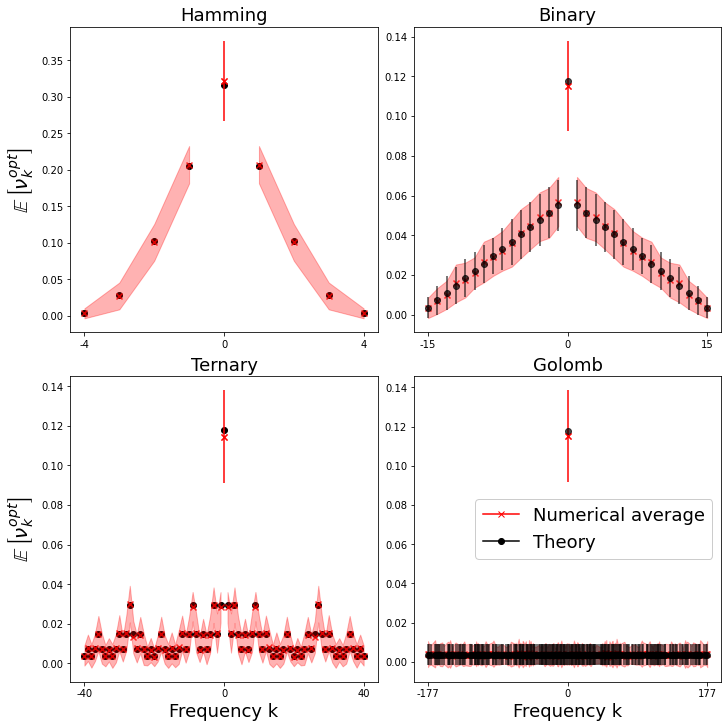

In [5]:
ntrials = 150
nvals = [4, 4, 4, 4]

fig, axes = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
numerical_style = {'c': 'r', 'marker': 'x'}
theory_style = {'c': 'k', 'marker': 'o'}

model_vars = [
    None, 
    nu_opt_haar_var_binary, 
    None, 
    nu_opt_haar_var_golomb]

# MODELS = [models.Hamming, models.Binary]
for i, Model in enumerate(models.ALL_MODELS):
    d = 2 ** nvals[i] 
    # Numerically sample the spectrum of this model 
    # with respect to Haar measure
    h_model = Model(d=d)
    spec_h = spectrum.get_frequency_spectrum(h_model.lambdas)
    results = {k: [] for k, _ in spec_h.items()}

    for _ in range(ntrials):
        state = qr_haar(d)[:,0]
        fourier_coefs = spectrum.get_fourier_coeffs(state, spec_h)
        for k, v in fourier_coefs.items():
            results[k].append(v)
  
    ax = axes.flatten()[i]
    num_avg = []
    num_std = []
    num_k = []
    for k, v in results.items():

        var = model_vars[i]
        if var is not None:
            ax.errorbar(k, nu_opt_haar_avg(h_model.degeneracy, k, d), yerr=np.sqrt(var(k, d)), alpha=0.7, **theory_style)
        else:
            ax.scatter(k, nu_opt_haar_avg(h_model.degeneracy, k, d), **theory_style)
        num_k.append(k)
        num_avg.append(np.average(v))
        num_std.append(np.std(v))
    
    # sort and plot the numerical errors
    idx = np.argsort(num_k)
    num_k = np.array(num_k)[idx]
    num_std = np.array(num_std)[idx]
    num_avg = np.array(num_avg)[idx]
    ax.scatter(num_k, num_avg, alpha=.8, **numerical_style)
    zero_idx = (len(num_k) - 1 ) // 2
    ax.fill_between(num_k[:zero_idx], 
                    num_avg[:zero_idx] - num_std[:zero_idx], 
                    num_avg[:zero_idx] + num_std[:zero_idx], 
                    alpha=0.3, color=numerical_style.get('c'))
    ax.fill_between(num_k[zero_idx+1:], 
                    num_avg[zero_idx+1:] - num_std[zero_idx+1:], 
                    num_avg[zero_idx+1:] + num_std[zero_idx+1:], 
                    alpha=0.3, color=numerical_style.get('c'))
    ax.errorbar(0, num_avg[zero_idx], yerr=num_std[zero_idx], **numerical_style)

    # prettier xticks
    ax.set_title(h_model.name, size=18)
    xticks = sorted(results.keys())
    labs = np.array([min(xticks), 0, max(xticks)], dtype=int)
    ax.set_xticks(labs)
    ax.set_xticklabels(labs)
    
    
line1 = Line2D([0], [0], label='Numerical average', **numerical_style)
line2= Line2D([0], [0], label='Theory', **theory_style)
axes[1,1].legend(handles=[line1, line2], prop={'size': 18}, 
                 loc='center right', framealpha=1)

for ax in axes[:,0]:
    ax.set_ylabel(r"$\mathbb{E} \, \left[ \nu_k^{opt} \right] $", size=20)
for ax in axes[-1,:]:
    ax.set_xlabel("Frequency k", size=18)
    
plt.savefig("../figures/figure6.pdf", bbox_inches="tight")
